In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmocean.cm as cmo
import netCDF4
import pandas as pd
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!
import seaborn as sns  # for better style in plots
from eofs.standard import Eof
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xarray as xr

In [4]:
sst = xr.open_dataset('/data/um/sst/hadisst_sst_mon_mean.nc', decode_times=True, autoclose=True, decode_coords=True)

In [5]:
#calculate nino 3.4 index
sst_tp         = sst.sel(time=slice('1895','2018'),longitude=slice(-170,-120),latitude=slice(5,-5))
tp_mn_climo    = sst_tp.sel(time=slice('1950','1979')).groupby(sst_tp.time.sel(time=slice('1950','1979')).dt.month).mean()
nino34         = sst_tp.sst.mean(axis=(1,2)) - np.tile(tp_mn_climo.sst.values, 2019-1895)
inds           = pd.DataFrame(data=nino34.values, index=nino34.time.values, columns=['nino34'])
inds['nino34'] = inds['nino34'].rolling(5, win_type='triang', center=True).mean()

In [6]:
#calculate amo index
sst_na       = sst.sel(time=slice('1895','2018'),longitude=slice(-80,0),latitude=slice(65,0))
sst_na_anom  = np.ma.masked_where(np.ma.masked_invalid(sst_na.sst.values) == -1000.0, np.ma.masked_invalid(sst_na.sst.values)).anom(axis=0)
na_am        = np.ma.average(np.ma.average(sst_na_anom, axis=1, weights=np.sort(sst_na.latitude.values)), axis=1)
na_am_linfit = np.polyfit(np.arange(na_am.shape[0]), na_am, deg=1)
na_am_lin    = na_am_linfit[0]*np.arange(na_am.shape[0])
na_am        = na_am - na_am_lin
buffer       = pd.DataFrame(data=na_am, index=sst_na.time, columns=['na_am'])
na_mn_climo  = buffer['na_am'].groupby(buffer['na_am'].index.month).mean()
amo          = na_am - np.tile(na_mn_climo.values, 2019-1895)
inds['amo']  = amo
inds['amo']  = inds['amo'].rolling(120, win_type='triang', center=True).mean()

In [7]:
#calculate pdo index
lon_np                       = np.roll(sst.longitude.values, 180)
lon_np[np.where(lon_np < 0)] = lon_np[np.where(lon_np < 0)] + 360
lon_np                       = lon_np[120:260]

sst_np = sst.sst.sel(time=slice('1895','2018'),latitude=slice(65,20)).values
sst_np = np.roll(sst_np, 180, axis=2)
sst_np = np.ma.masked_invalid(np.ma.masked_where(sst_np[:,:,120:260] == -1000.0, sst_np[:,:,120:260]))

time_np = sst.time.sel(time=slice('1895','2018')).values

for i in np.arange(sst_np.shape[1]):
    for j in np.arange(sst_np.shape[2]):
        if (np.any(np.isfinite(sst_np[:,i,j]))):
            np_poly       = np.polyfit(np.arange(sst_np.shape[0]), sst_np[:,i,j], deg=1)
            np_linfit     = np_poly[0]*np.arange(sst_np.shape[0])
            sst_np[:,i,j] = sst_np[:,i,j] - np_linfit
        
        buffer        = pd.DataFrame(data=sst_np[:,i,j], index=time_np)
        mn_sc         = buffer.groupby(buffer.index.month).mean()
        tile_mn_sc    = np.tile(mn_sc.T, 2019-1895)
        sst_np[:,i,j] = sst_np[:,i,j] - tile_mn_sc

solver      = Eof(sst_np, weights=np.cos(np.deg2rad(sst.latitude.sel(latitude=slice(65,20)).values))[...,np.newaxis])
np_eof      = -solver.eofs(neofs=1)
inds['pdo'] = -solver.pcs(npcs=1, pcscaling=0)

inds['pdo'] = inds['pdo']/np.std(inds['pdo'])
inds['pdo'] = inds['pdo'].rolling(120, center=True, win_type='triang').mean()


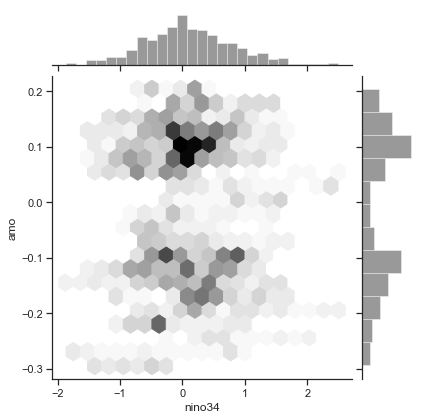

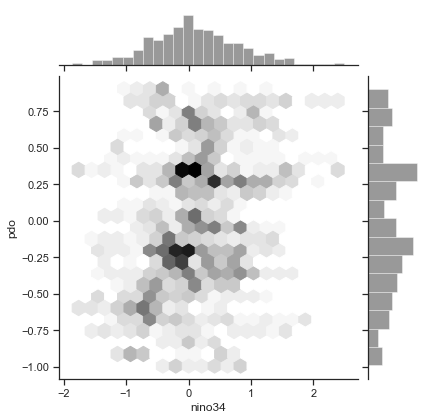

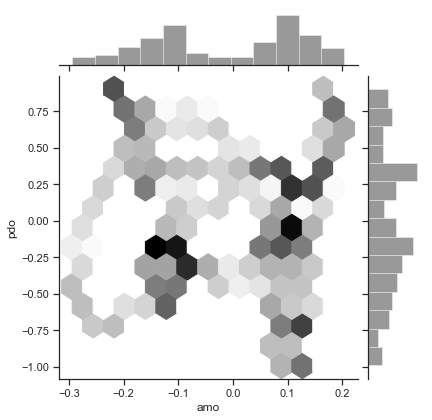

In [8]:
sns.set(style="ticks")
sns.jointplot(inds['nino34'], inds['amo'], kind="hex", color="black")
sns.jointplot(inds['nino34'], inds['pdo'], kind="hex", color="black")
sns.jointplot(   inds['amo'], inds['pdo'], kind="hex", color="black")

In [13]:
amo    =    inds['amo'].values[~np.isnan(inds['amo'].values)]
pdo    =    inds['pdo'].values[~np.isnan(inds['pdo'].values)]
nino34 = inds['nino34'].values[~np.isnan(inds['amo'].values)]

amop     = nino34[(amo > 0)]
amon     = nino34[(amo < 0)]
pdop     = nino34[(pdo > 0)]
pdon     = nino34[(pdo < 0)]
amoppdop = nino34[(amo > 0) & (pdo > 0)]
amoppdon = nino34[(amo > 0) & (pdo < 0)]
amonpdop = nino34[(amo < 0) & (pdo > 0)]
amonpdon = nino34[(amo < 0) & (pdo < 0)]

labels = ['Nino 3.4', 
          'AMO +', 'AMO -', 
          'PDO +', 'PDO -', 
          'AMO + PDO +', 'AMO + PDO -', 
          'AMO - PDO +', 'AMO - PDO -']

nino34_case_amps = (nino34, amop, amon, pdop, pdon, amoppdop, amoppdon, amonpdop, amonpdon)

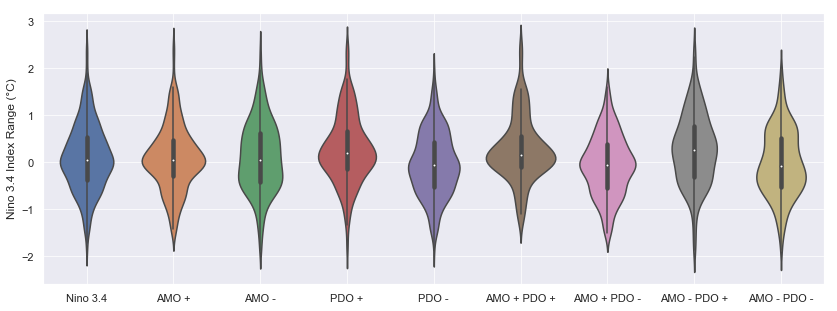

In [33]:
sns.set()
# Use cubehelix to get a custom sequential palette
pal = sns.cubehelix_palette(10, rot=-.5, dark=.3)
# Show each distribution with both violins and points
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5))

sns.violinplot(data=nino34_case_amps, inner='box', ax=ax)
ax.set_ylabel('Nino 3.4 Index Range (°C)')
ax.set_xticklabels(labels)
ax.grid(alpha=.75)